# Hudba a neurónové siete
## Bakárska práca
### Peter Oliver Kolek

In [1]:
from mido import MidiFile, MidiTrack, MetaMessage, bpm2tempo, Message
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.utils import np_utils
import matplotlib.pyplot as plt
import keras
from scipy.stats import gmean

In [2]:
def get_list_of_content(file_name):
    f = open(file_name, "r")
    return f.read().splitlines()

In [3]:
def open_midi(midi_file):
    # open midi file
    mid = MidiFile(midi_file, clip=True)

    drum_track_number = 0
    # find track number of drums
    for i in range(len(mid.tracks)):
        for j in range(len(mid.tracks[i])):
            if mid.tracks[i][j].is_meta:
                continue
            if mid.tracks[i][j].channel == 9:
                drum_track_number = i
                break
    print("Drum track number: ", str(drum_track_number))
    return mid, mid.tracks[drum_track_number]

In [4]:
def get_transcription(drum_track, mid):
    # find ticks per beat, and divide it to Thirty-Second 32 notes
    ticks_per_beat_in_32_notes = mid.ticks_per_beat / 8
#     print(ticks_per_beat_in_32_notes)
    # change notes time to stick it to 32 notes
    tmp_time = 0
    time_with_note = {}
    for i, message in enumerate(drum_track):
        # find time how it goes through song
        tmp_time += drum_track[i].time
        message.time = round(tmp_time / ticks_per_beat_in_32_notes)
#         print("i: ", i, "msg time: ", message.time, "tmp time: ", tmp_time, "Msg_type: ", message.type)
        # make velocity of notes same
        if message.type == 'note_on':
            if message.velocity > 0:
                message.velocity = 1

    # crating DataFrame for notes sticked to 32s and filter only note_on notes
    transcription = pd.DataFrame(m.dict() for m in drum_track)
    transcription = transcription[transcription.type == 'note_on']
    # modify table to have columns for every note and lines with time (32 notes as they folow the song)
    transcription = transcription.pivot_table(index='time', columns='note', values='velocity', fill_value=0)
    # because we have 4/4 tempo, we have to add notes to have folowing 32 notes and empty values we fill with zeros
    transcription = transcription.reindex(pd.RangeIndex(transcription.index.max() + 1)).fillna(0).sort_index()
    # retype to int
    transcription = transcription.astype(int)
    transcription.columns = transcription.columns.astype(int)
    transcription = transcription.reset_index(drop=True)
    return transcription

In [5]:
def create_midi(tempo, transcription, ticks_per_beat, file_name, instruments):
    # create new midi file
    new_mid = MidiFile()
    new_mid.ticks_per_beat = ticks_per_beat
    meta_track = MidiTrack()
    new_mid.tracks.append(meta_track)

    # necessary meta track
    meta_track.append(MetaMessage(type='track_name', name='meta_track', time=0))
    meta_track.append(MetaMessage(type='time_signature', numerator=4, denominator=4, clocks_per_click=24,
                                  notated_32nd_notes_per_beat=8, time=0))
    meta_track.append(MetaMessage(type='set_tempo', tempo=bpm2tempo(tempo), time=0))

    drum_track_new = MidiTrack()
    new_mid.tracks.append(drum_track_new)

    # apend notes to drum track

    ticks_per_32note = int(ticks_per_beat/8)
    notes_from_last_message = 0
    for i, note in enumerate(transcription):
        if i == 0:
            for idx, inst in enumerate(note):
                if inst == 0:
                    continue
                drum_track_new.append(Message('note_on', channel=9, note=instruments[idx], velocity=80, time=0))
            continue
        else:
            if sum(note) < 1:
                notes_from_last_message += 1
                continue
            else:
                notes_from_last_message += 1

            same_note_count = 0
            for idx, inst in enumerate(note):
                if inst == 0:
                    pass
                # if there are more notes at the same time played, they must have time 0
                elif same_note_count == 0:
                    drum_track_new.append(Message('note_on', channel=9, note=instruments[idx], velocity=80,
                                                  time=notes_from_last_message * ticks_per_32note))
                    same_note_count += 1
                else:
                    drum_track_new.append(Message('note_on', channel=9, note=instruments[idx], velocity=80, time=0))
                    same_note_count += 1
            notes_from_last_message = 0
#     print(new_mid)
    new_mid.save(file_name)

In [7]:
slipknot_list = get_list_of_content('./Slipknot_midi/list.txt')
print(slipknot_list)

['BeforeIForget.midi', 'Eyeless.midi', 'TheNameless.midi', 'Disasterpiece.midi', 'People=Shit.midi', 'WaitAndBleed.midi', 'Duality.midi', 'Sic.midi', 'Eeyore.midi', 'Surfacing.midi']


In [9]:
slipknot_transcription_full = pd.DataFrame()
frames = []
for item in rhcp_list:
    mid, drum_track = open_midi('./Slipknot_midi/' + item)
    transcription = get_transcription(drum_track, mid)
    frames.append(transcription)
    instruments = transcription.columns.tolist()


instruments = slipknot_transcription_full.columns.tolist()
slipknot_transcription_full = pd.concat(frames)
slipknot_transcription_full = slipknot_transcription_full.fillna(0)
slipknot_transcription_full = slipknot_transcription_full.astype(int)
slipknot_transcription_full = slipknot_transcription_full.reset_index(drop=True)

instruments = slipknot_transcription_full.columns.tolist()

create_midi(120, slipknot_transcription_full.values, mid.ticks_per_beat, "./output/transcription_full_slipknot.mid", instruments)

print(slipknot_transcription_full)

Drum track number:  7
Drum track number:  3
Drum track number:  5
Drum track number:  3
Drum track number:  6
Drum track number:  1
Drum track number:  4
Drum track number:  4
Drum track number:  5
Drum track number:  6
note   35  38  40  41  43  45  46  47  49  57  ...  37  42  44  48  51  55  \
0       0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
1       0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
2       0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
3       0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
4       0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..   
45218   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
45219   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
45220   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   


In [17]:
train_test_split = int(slipknot_transcription_full.shape[0]*0.7)
train_test_split

31656

In [18]:
train = slipknot_transcription_full.loc[:train_test_split]
test = slipknot_transcription_full.loc[train_test_split:]

In [20]:
inputs_list = []
outputs_list = []
sequence_len = 32
raw_notes = train.values
for i in range(len(raw_notes) - sequence_len):
    input_start = i
    input_end = i + sequence_len
    output_start = input_end
    output_end = output_start + 1

    # for every 32 notes sequence set next note as output
    inputs_list.append(raw_notes[input_start:input_end])
    outputs_list.append(raw_notes[output_start:output_end])

outputs_list = list(np.array(outputs_list).reshape(-1, np.array(outputs_list).shape[-1]))

inputs_list = np.array(inputs_list)
outputs_list = np.array(outputs_list)

output_shape = outputs_list.shape[1]

test_list = []
test_out = []
raw_notes = test.values
for i in range(len(raw_notes) - sequence_len):
    input_start = i
    input_end = i + sequence_len
    output_start = input_end
    output_end = output_start + 1

    # for every 32 notes sequence set next note as output
    test_list.append(raw_notes[input_start:input_end])
    test_out.append(raw_notes[output_start:output_end])

test_out = list(np.array(test_out).reshape(-1, np.array(test_out).shape[-1]))

test_list = np.array(test_list)
test_out = np.array(test_out)

In [31]:
dropout = 0.2

# very very very basic LSTM model
model = Sequential()
model.add(LSTM(sequence_len, input_shape=(sequence_len, len(instruments)), return_sequences=True, dropout=dropout))
model.add(LSTM(sequence_len, return_sequences=True, dropout=dropout))
model.add(LSTM(sequence_len, dropout=dropout))
model.add(Dense(output_shape, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',keras.metrics.BinaryCrossentropy()])
model.summary()
mc = ModelCheckpoint(filepath='./new_encode_1st_try.h5', monitor='val_loss', verbose=1, save_best_only=True)

history = model.fit(inputs_list, outputs_list, epochs=50, callbacks=mc, validation_split=0.1, verbose=1, shuffle=False)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 32, 32)            7040      
                                                                 
 lstm_4 (LSTM)               (None, 32, 32)            8320      
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 22)                726       
                                                                 
Total params: 24,406
Trainable params: 24,406
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
890/890 [==============================] - ETA: 0s - loss: 0.0921 - accuracy: 0.2342 - binary_crossentropy: 0.0921
Epoch 1: val_loss improved from inf to 0.07161, saving m

890/890 [==============================] - 20s 22ms/step - loss: 0.0522 - accuracy: 0.2127 - binary_crossentropy: 0.0522 - val_loss: 0.0609 - val_accuracy: 0.0828 - val_binary_crossentropy: 0.0609
Epoch 20/50
890/890 [==============================] - ETA: 0s - loss: 0.0514 - accuracy: 0.1776 - binary_crossentropy: 0.0514
Epoch 20: val_loss did not improve from 0.05895
890/890 [==============================] - 20s 22ms/step - loss: 0.0514 - accuracy: 0.1776 - binary_crossentropy: 0.0514 - val_loss: 0.0612 - val_accuracy: 0.0885 - val_binary_crossentropy: 0.0612
Epoch 21/50
888/890 [============================>.] - ETA: 0s - loss: 0.0511 - accuracy: 0.1770 - binary_crossentropy: 0.0511
Epoch 21: val_loss did not improve from 0.05895
890/890 [==============================] - 20s 22ms/step - loss: 0.0511 - accuracy: 0.1770 - binary_crossentropy: 0.0511 - val_loss: 0.0598 - val_accuracy: 0.0835 - val_binary_crossentropy: 0.0598
Epoch 22/50
890/890 [==============================] - ETA:

Epoch 41/50
888/890 [============================>.] - ETA: 0s - loss: 0.0343 - accuracy: 0.2252 - binary_crossentropy: 0.0343
Epoch 41: val_loss did not improve from 0.04937
890/890 [==============================] - 20s 22ms/step - loss: 0.0343 - accuracy: 0.2251 - binary_crossentropy: 0.0343 - val_loss: 0.0496 - val_accuracy: 0.1021 - val_binary_crossentropy: 0.0496
Epoch 42/50
888/890 [============================>.] - ETA: 0s - loss: 0.0337 - accuracy: 0.2291 - binary_crossentropy: 0.0337
Epoch 42: val_loss improved from 0.04937 to 0.04912, saving model to ./new_encode_1st_try.h5
890/890 [==============================] - 20s 23ms/step - loss: 0.0337 - accuracy: 0.2290 - binary_crossentropy: 0.0337 - val_loss: 0.0491 - val_accuracy: 0.1088 - val_binary_crossentropy: 0.0491
Epoch 43/50
889/890 [============================>.] - ETA: 0s - loss: 0.0331 - accuracy: 0.2197 - binary_crossentropy: 0.0331
Epoch 43: val_loss improved from 0.04912 to 0.04896, saving model to ./new_encode_1s

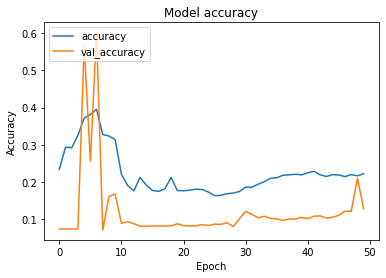

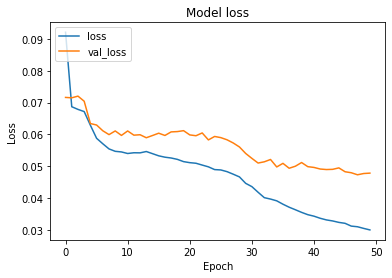

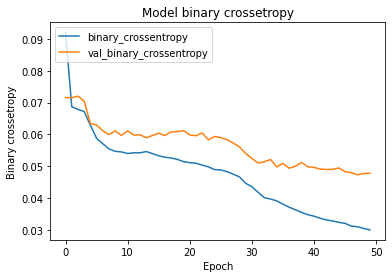

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

plt.plot(history.history['binary_crossentropy'])
plt.plot(history.history['val_binary_crossentropy'])
plt.title('Model binary crossetropy')
plt.ylabel('Binary crossetropy')
plt.xlabel('Epoch')
plt.legend(['binary_crossentropy', 'val_binary_crossentropy'], loc='upper left')

plt.show()

In [39]:
# predict new notes
prediction = model.predict(test_list[640:1280], verbose=0)
# round prediction to 1 or 0
prediction = np.around(prediction)
# retype it to int
prediction = prediction.astype(int)

In [40]:
np.unique(prediction)

array([0, 1])

In [41]:
bpm = 160
file_name = "./output/test_slipknot2.mid"
create_midi(bpm, prediction, mid.ticks_per_beat, file_name, instruments)
# create_midi(bpm, transcription.values, mid.ticks_per_beat, "./output/transcription.mid", instruments)

In [17]:
def bleu_metric_complete_lines(candidate, reference):
    correct_lines = 0
    for i,c in enumerate(candidate):
        # line of candidate is the same as reference
        if (c == reference[i]).all() == True:
            correct_lines += 1
    
    # probability of correct lines
    return correct_lines/len(reference)

def bleu_metric_ngrams(candidate, reference, ngram):
    correct_ngrams = 0
    offset = 0
    true_flag = True
    
    for i,c in enumerate(candidate):
        
#         print(candidate[i+offset], reference[i+offset], (candidate[i+offset] == reference[i+offset]).all())
        # line is correct
        if (candidate[i] == reference[i]).all() == True:
            pass
        else:
            true_flag = False

        # every ngram sequence
        if (i+1)%ngram == 0:
#             print(i, true_flag)
            # all sequence is correct
            if true_flag:
                correct_ngrams += 1
            true_flag = True
    
    allngrams = len(reference)/ngram
#     print(correct_ngrams, allngrams)
    # probability of correct lines
    return correct_ngrams/allngrams

def bleu_metric_single_notes(candidate, reference, length_of_line):
    correct_lines = 0
    probabilities = []
    for i,c in enumerate(candidate):
        # how many notes are correct in single line
        tmp = ((c == reference[i]) == True).sum()
        # probability of correct notes in single line
        probabilities.append(tmp/length_of_line)
    
    # geometric mean of probabilities
    return gmean(probabilities)

In [18]:
candidate = prediction.copy()
reference = test_list.copy()

In [19]:
bleu_metric_complete_lines(candidate, reference)

0.0

In [20]:
bleu_metric_single_notes(candidate, reference, length_of_line=len(instruments))

30.836420773258553

In [21]:
bleu_metric_ngrams(candidate, reference, 16)

0.0